In [1]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    
    a = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    #print(a)
    #print(a[:,2])
    #print(-1*a[:,1])
    a = a[ np.lexsort((a[:,2], -1*a[:,1])) ]
    #print(a)
    totalLosses = a[:,0].sum()
    #print(totalLosses)
    giniSum = a[:,0].cumsum().sum() / totalLosses
    #print(a[:,0].cumsum()/ totalLosses)
    giniSum -= (len(actual) + 1) / 2.
    #print((len(actual) + 1) / 2)
    return giniSum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)
 
def test_gini():
    def fequ(a,b):
        return abs( a -b) < 1e-6
    def T(a, p, g, n):
        assert( fequ(gini(a,p), g) )
        assert( fequ(gini_normalized(a,p), n) )


In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgbm

In [3]:
train=pd.read_csv('train.csv',index_col=0)
test=pd.read_csv('test.csv',index_col=0)

In [4]:
train['missing'] = (train==-1).sum(axis=1).astype(float)
test['missing'] = (test==-1).sum(axis=1).astype(float)

In [5]:
feature_names = train.columns.tolist()
calc_features = [c for c in feature_names if ('calc' in c)]

In [6]:
train=train.drop(calc_features,axis=1)
test=test.drop(calc_features,axis=1)

In [7]:
#test=test.drop(calc_features+['ps_reg_03','ps_car_03_cat','ps_car_05_cat','ps_car_14'],axis=1)
#train=train.drop(calc_features+['ps_reg_03','ps_car_03_cat','ps_car_05_cat','ps_car_14'],axis=1)

In [8]:
len(train)

595212

In [9]:
#train=train[(train==-1).sum(axis=1)==0]

In [10]:
# feature_names = test.columns.tolist()
# for f in feature_names:
#     test[f].replace(-1,test[f].mode().values[0],inplace=True)
#     #print(sum(test[f]==-1))

In [11]:
(test==-1).sum()

ps_ind_01             0
ps_ind_02_cat       307
ps_ind_03             0
ps_ind_04_cat       145
ps_ind_05_cat      8710
ps_ind_06_bin         0
ps_ind_07_bin         0
ps_ind_08_bin         0
ps_ind_09_bin         0
ps_ind_10_bin         0
ps_ind_11_bin         0
ps_ind_12_bin         0
ps_ind_13_bin         0
ps_ind_14             0
ps_ind_15             0
ps_ind_16_bin         0
ps_ind_17_bin         0
ps_ind_18_bin         0
ps_reg_01             0
ps_reg_02             0
ps_reg_03        161684
ps_car_01_cat       160
ps_car_02_cat         5
ps_car_03_cat    616911
ps_car_04_cat         0
ps_car_05_cat    400359
ps_car_06_cat         0
ps_car_07_cat     17331
ps_car_08_cat         0
ps_car_09_cat       877
ps_car_10_cat         0
ps_car_11_cat         0
ps_car_11             1
ps_car_12             0
ps_car_13             0
ps_car_14         63805
ps_car_15             0
missing               0
dtype: int64

In [12]:
pos_train=train[train['target']==1]
neg_train=train[train['target']==0]

In [13]:
train_label = np.array(list((train['target'])))
train_id = list(train.index)
test_id = list(test.index)
train=train.drop('target',axis=1)

In [14]:
train.shape

(595212, 38)

In [15]:
feature_names = train.columns.tolist()
ind_features = [c for c in feature_names if 'ind' in c]
cat_features = [c for c in feature_names if ('cat' in c and 'count' not in c)]
count=0
for c in ind_features:
    if count==0:
        train['new_ind'] = train[c].astype(str)+'_'
        test['new_ind'] = test[c].astype(str)+'_'
        count+=1
    else:
        train['new_ind'] += train[c].astype(str)+'_'
        test['new_ind'] += test[c].astype(str)+'_'
        

cat_count_features = []
for c in cat_features:
    print(c)
#     pos_d=pos_train[c].value_counts().to_dict()
#     neg_d=neg_train[c].value_counts().to_dict()
#     train['%s_R_count'%c] = train[c].apply(lambda x:pos_d.get(x,0)/(pos_d.get(x,0)+neg_d.get(x,0)))
#     test['%s_R_count'%c] = test[c].apply(lambda x:pos_d.get(x,0)/(pos_d.get(x,0)+neg_d.get(x,0)))
    d = pd.concat([train[c],test[c]]).value_counts().to_dict()
    train['%s_count'%c] = train[c].apply(lambda x:d.get(x,0))
    test['%s_count'%c] = test[c].apply(lambda x:d.get(x,0))
    #cat_count_features.append('%s_count'%c)

ps_ind_02_cat
ps_ind_04_cat
ps_ind_05_cat
ps_car_01_cat
ps_car_02_cat
ps_car_03_cat
ps_car_04_cat
ps_car_05_cat
ps_car_06_cat
ps_car_07_cat
ps_car_08_cat
ps_car_09_cat
ps_car_10_cat
ps_car_11_cat


In [16]:
c='new_ind'
d = pd.concat([train[c],test[c]]).value_counts().to_dict()
train['%s_count'%c] = train[c].apply(lambda x:d.get(x,0))
test['%s_count'%c] = test[c].apply(lambda x:d.get(x,0))

In [13]:
train.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_car_07_cat_count,ps_car_08_cat_R_count,ps_car_08_cat_count,ps_car_09_cat_R_count,ps_car_09_cat_count,ps_car_10_cat_R_count,ps_car_10_cat_count,ps_car_11_cat_R_count,ps_car_11_cat_count,new_ind_count
id,,,,,,,,,,,,,,,,,,,,,
7,2,2,5,1,0,0,1,0,0,0,...,1383070,4491,249663,6486,486510,21520,1475460,280,18326,6
9,1,1,7,0,0,0,0,1,0,0,...,1383070,17203,1238365,12838,883326,21520,1475460,122,12535,36
13,5,4,9,1,0,0,0,1,0,0,...,1383070,17203,1238365,12838,883326,21520,1475460,250,19943,24
16,0,1,2,0,0,1,0,0,0,0,...,1383070,17203,1238365,518,36798,21520,1475460,3830,212989,2784
17,0,2,0,1,0,1,0,0,0,0,...,1383070,17203,1238365,12838,883326,21520,1475460,275,26161,258


In [14]:
train.columns

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'missing',
       'new_ind', 'ps_ind_02_cat_R_count', 'ps_ind_02_cat_count',
       'ps_ind_04_cat_R_count', 'ps_ind_04_cat_count', 'ps_ind_05_cat_R_count',
       'ps_ind_05_cat_count', 'ps_car_01_cat_R_count', 'ps_car_01_cat_count',
       'ps_car_02_cat_R_count', 'ps_car_02_cat_count', 'ps_car_03_cat_R_count',
       'ps_car_03_cat_count', 'ps_car_04_

(array([  51126.,   35856.,   50500.,   57532.,   40472.,   31843.,
          68326.,   47764.,   57378.,  142050.]),
 array([   1. ,   11.3,   21.6,   31.9,   42.2,   52.5,   62.8,   73.1,
          83.4,   93.7,  104. ]),
 <a list of 10 Patch objects>)

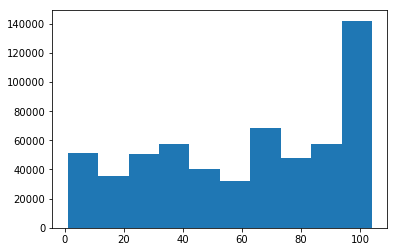

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(train['ps_car_11_cat'])

In [28]:
train.iloc[:20,20:40]

,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07
id,,,,,,,,,,,,,,,,,,,,
7,10,1,0,4,1,0,0,1,12,2,0.400000,0.883679,3.605551,0.6,0.5,0.2,3,1,10,1
9,11,1,0,11,1,1,2,1,19,3,0.316228,0.618817,2.449490,0.3,0.1,0.3,2,1,9,5
13,7,1,0,14,1,1,2,1,60,1,0.316228,0.641586,3.316625,0.5,0.7,0.1,2,2,9,1
16,7,1,0,11,1,1,3,1,104,1,0.374166,0.542949,2.000000,0.6,0.9,0.1,2,4,7,1
17,11,1,0,14,1,1,2,1,82,3,0.316070,0.565832,2.000000,0.4,0.6,0.0,2,2,6,3
19,10,0,0,14,1,1,0,1,104,2,0.445982,0.879049,3.000000,0.7,0.8,0.4,3,1,8,2
20,6,1,0,11,1,1,0,1,99,2,0.316228,0.639683,3.162278,0.2,0.6,0.5,2,2,8,1
22,11,1,0,11,1,1,2,1,30,3,0.446990,0.900574,3.316625,0.1,0.5,0.1,1,2,7,1
26,10,1,0,14,1,1,0,1,68,3,0.400000,0.780641,2.828427,0.9,0.8,0.6,3,1,7,3


In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

feature_names = train.columns.tolist()
cat_features = [c for c in feature_names if ('cat' in c and 'count' not in c)]
all_df=train.append(test)
for c in cat_features:
    print(c)
    le = LabelEncoder()
    le.fit(all_df[c])
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])
all_df=train.append(test)
enc = OneHotEncoder()
enc.fit(all_df[cat_features])
X_cat = enc.transform(train[cat_features])
X_t_cat = enc.transform(test[cat_features])


ps_ind_02_cat
ps_ind_04_cat
ps_ind_05_cat
ps_car_01_cat
ps_car_02_cat
ps_car_03_cat
ps_car_04_cat
ps_car_05_cat
ps_car_06_cat
ps_car_07_cat
ps_car_08_cat
ps_car_09_cat
ps_car_10_cat
ps_car_11_cat


In [18]:
feature_names = train.columns.tolist()
other_features = [c for c in feature_names if (('cat' not in c or 'count' in c)and c != 'new_ind')]

In [19]:
other_features

['ps_ind_01',
 'ps_ind_03',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'missing',
 'ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'new_ind_count']

In [20]:
from scipy import sparse as ssp
train_list = [train[other_features].values,X_cat]
test_list = [test[other_features].values,X_t_cat]

X = ssp.hstack(train_list).tocsr()
X_test = ssp.hstack(test_list).tocsr()

In [21]:
from sklearn.model_selection import StratifiedKFold
NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=218)

def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return ('gini', gini_normalized(labels, preds), True)

cv_only=True
learning_rate = 0.1
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.6
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9
          }

x_score = []
final_cv_train = np.zeros(len(train_label))
final_cv_pred = np.zeros(len(test_id))
for s in np.arange(16):
    cv_train = np.zeros(len(train_label))
    cv_pred = np.zeros(len(test_id))

    params['seed'] = s


    kf = kfold.split(X, train_label)

    best_trees = []
    fold_scores = []

    for i, (train_fold, validate) in enumerate(kf):
        #print(train_fold)
        X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], train_label[train_fold], train_label[validate]
        #print((label_train))
        #print(sum(label_validate))
        dtrain = lgbm.Dataset(X_train, label_train)
        dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)
        bst = lgbm.train(params, dtrain, num_boost_round, valid_sets=dvalid, feval=evalerror, verbose_eval=100,early_stopping_rounds=100)
        best_trees.append(bst.best_iteration)
        cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration)
        cv_train[validate] += bst.predict(X_validate)

        score = gini_normalized(label_validate, cv_train[validate])
        print (score)
        fold_scores.append(score)

    cv_pred /= NFOLDS
    final_cv_train += cv_train
    final_cv_pred += cv_pred

    print("cv score:")
    print (gini_normalized(train_label, cv_train))
    print ("current score:", gini_normalized(train_label, final_cv_train / (s + 1.)), s+1)
    print(fold_scores)
    print(best_trees, np.mean(best_trees))

    x_score.append(gini_normalized(train_label, cv_train))

print(x_score)

/home/yicheng/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's gini: 0.28953
[200]	valid_0's gini: 0.295885
[300]	valid_0's gini: 0.295852
[400]	valid_0's gini: 0.296148
Early stopping, best iteration is:
[335]	valid_0's gini: 0.297182
0.297181509039
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's gini: 0.271764
[200]	valid_0's gini: 0.275092
[300]	valid_0's gini: 0.274831
Early stopping, best iteration is:
[236]	valid_0's gini: 0.275719
0.275719339217
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's gini: 0.277396
[200]	valid_0's gini: 0.281107
[300]	valid_0's gini: 0.281007
Early stopping, best iteration is:
[217]	valid_0's gini: 0.281511
0.281511238354
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's gini: 0.281579
[200]	valid_0's gini: 0.285791
Early stopping, best iteration is:
[194]	valid_0's gini: 0.286198
0.28619772768
Training until validation scores don't improve for 100

KeyboardInterrupt: 

In [22]:
learning_rate = 0.1
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.6
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9
          }
final_valid_length=15000
dtrain = lgbm.Dataset(X[:X.shape[0]-final_valid_length], train_label[:X.shape[0]-final_valid_length])
dvalid = lgbm.Dataset(X[X.shape[0]-final_valid_length:], train_label[X.shape[0]-final_valid_length:], reference=dtrain)
bst = lgbm.train(params, dtrain, num_boost_round, valid_sets=dvalid, feval=evalerror, verbose_eval=100,early_stopping_rounds=100)


/home/yicheng/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's gini: 0.298142
[200]	valid_0's gini: 0.301308
[300]	valid_0's gini: 0.302222
[400]	valid_0's gini: 0.301204
Early stopping, best iteration is:
[333]	valid_0's gini: 0.30486


In [196]:
X.shape

(582847, 212)

In [31]:
# import xgboost as xgb
# # read in data
# dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
# dtest = xgb.DMatrix('demo/data/agaricus.txt.test')
# # specify parameters via map
# param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
# num_round = 2
# bst = xgb.train(param, dtrain, num_round)
# # make prediction
# preds = bst.predict(dtest)


In [16]:
len(train)

582847

In [83]:
balance_id=list(pos_id)+list(neg_id)[:len(pos_id)*2]
train=train.loc[balance_id]

In [84]:
import sklearn
from sklearn.model_selection import train_test_split
X=train.drop(['target'],axis=1)
Y=train['target']
test_size=int(len(Y)*0.1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

In [19]:
from xgboost import XGBClassifier


from sklearn.ensemble import RandomForestClassifier

/home/yicheng/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
xgb=XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [21]:
res=xgb.predict(X_test)

In [45]:
# rf=RandomForestClassifier(5000)
# rf.fit(X_train,y_train)

In [144]:
# res=rf.predict(X_test)

In [24]:
gini_normalized(y_test,res)

0.18084657007189381

In [25]:
1-sum(abs(res-np.array(y_test)))/len(y_test)

0.59257473481195755

In [26]:
res[100:200]

array([0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1])

In [27]:
np.array(y_test[100:200])

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1])

In [132]:
# a=[0,0,0,0,0,1,1,1]
# b=[0,0,0,0,0.4,0.5,1,1]
# gini(a,b)

In [28]:
gini_normalized(np.array(y_test),res)

0.18084657007189381

In [89]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return ('gini', gini_normalized(labels, preds), True)
import lightgbm as lgbm
learning_rate = 0.1
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.3
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": True,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9
          }


X_train, X_validate, label_train, label_validate =  X_train, X_test, y_train, y_test
dtrain = lgbm.Dataset(X_train, label_train)
dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)
bst = lgbm.train(params, dtrain, num_boost_round, valid_sets=dvalid, feval=evalerror, verbose_eval=100,early_stopping_rounds=100)
# best_trees.append(bst.best_iteration)

score = gini_normalized(label_validate, bst.predict(X_validate))


/home/yicheng/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's gini: 0.254981
[200]	valid_0's gini: 0.25241
Early stopping, best iteration is:
[128]	valid_0's gini: 0.256888


In [23]:
submission=bst.predict(X_test)

In [24]:
#test['target']=final_cv_pred/16
test['target']=submission

In [25]:
sub=pd.DataFrame(test['target'])
sub.to_csv('sub1.csv')

In [26]:
len(sub)

892816

In [27]:
sub

,target
id,
0,0.031070
1,0.022780
2,0.019897
3,0.012835
4,0.038763
5,0.053921
6,0.017985
8,0.041478
10,0.051225


In [52]:
tester=train.loc[list(neg_id)[len(pos_id):len(pos_id)+50000]]
X=tester.drop(['target'],axis=1)

In [55]:
new_res=bst.predict(X)